# DSE Course 3, Session 2: FFNNs with Keras/TensorFlow

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

<br>

---

<br>

In this session we will continue with our discussion on neural networks. Specifically, we will revisit the concept of learning curves that we covered in course 2, regularization that we covered in course 1 and classification tasks (course 1 and 2), this time as they pertain to neural networks!

<br>

---

<br>

<a name='top'></a>

# Contents

* 2.0 [Preparing Environment and Importing Data](#x.0)
  * 2.0.1 [Import Packages](#x.0.1)
  * 2.0.2 [Load Dataset](#x.0.2)
* 2.1 [Feature Engineering](#x.1)
* 2.2 [Building the Model](#x.2)
  * 2.2.1 [Layers, Nodes, and Activation Functions](#x.2.1)
* 2.3 [Compiling the Model](#x.3)
  * 2.3.1 [Loss, Optimizer, and Metrics](#x.3.1)
* 2.4 [Fitting the Model](#x.4)
  * 2.4.1 [Epoch, Batch](#x.4.1)
* 2.5 [Evaluating the Model](#x.5)
* 2.6 [Convolutional NNs](#x.6)
  * 2.6.1 [Convolutional Layers](#x.6.1)
  * 2.6.2 [Pooling Layers](#x.6.2)
  * 2.6.3 [Flattening](#x.6.3)
  * 2.6.4 [Dropout](#x.6.4)
  
  

<br>

---

<a name='x.0'></a>

## 2.0 Preparing Environment and Importing Data

[back to top](#top)

In [ ]:
# !pip uninstall scikit-learn -y

# !pip install -U scikit-learn

Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 22.3MB 1.4MB/s 


<a name='x.0.1'></a>

### 2.0.1 Import Packages

[back to top](#top)

In [76]:
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from copy import copy
import numpy as np
sns.set()

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# set_config(display='diagram')

<a name='x.0.1'></a>

### 2.0.2 Load Dataset

[back to top](#top)

In [17]:
wine = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
      "ds_for_engineers/main/data/wine_quality/winequalityN.csv")

# create X and y
X = wine.copy()
y = X.pop('quality')

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y)

# the numerical values pipe
num_proc = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

# the categorical values pipe
cat_proc = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore'))

# parallelize the two pipes
preprocessor = make_column_transformer((num_proc,
                                make_column_selector(dtype_include=np.number)),
                                       (cat_proc,
                                make_column_selector(dtype_include=object)))

X_train_std = preprocessor.fit_transform(X_train) # fit_transform on train
X_test_std = preprocessor.transform(X_test) # transform test
y_train_std = np.log(y_train) # log output y
y_test_std = np.log(y_test) # log output y

preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd5cfc27f50>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd573dbae90>)])

<a name='x.1'></a>

## 2.1 Evaluating the Model

[back to top](#top)

In the last session, we randomly chose 10 epochs (10 rounds of the training data) to train our neural network. Now we'll garner the language to be more systematic in our approach.

### 2.1.1 Learning Curves

Recall learning curves from Session 2, where we plot model score (accuracy/mse/r2/etc.) over model complexity (trees in a forest, degrees in a polynomial, etc.):

<p align=center>
<img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png" width=500px></img>


<small>[img src](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html)

</p>

We have a similar situation with neural networks, accept here, the model complexity is defined by both the number of epochs, and the capacity of the model. 

#### 2.1.1.1 Training Data (Epochs)

A greater number of epochs allows the model to further tune itself to the training data. Remember that our model solves its weights by a solver function, most often a form of stochastic gradient descent. Because this solver is iterative, the longer we allow it run the closer it will get to finding its true weights. The caveat here is that, like we have seen before, the model is only learning the proper weights according to the training data, which we know includes noise, otherwise known as irreducible error. Our data science senses should be tingling: there's an optimum number of epochs here, and it will counter balance the trade-off between error due to bias (too few epochs) and error due to variance (too many epochs).

#### 2.1.1.2 Complexity (Capacity)



The capacity of the model is defined by the architecture. It is the total number of trainable weights available to the solver function. The more weights, the more capacity. Capacity determines the upper limit for which our model can learn relationships between the data. Again we should recall from our session on feature engineering: the more training data we have, the more capacity we should give our model to account for that abundance of training data. This is also influenced by the actual complexity between the input and output data, X and y, who's function we are attempting to approximate with the neural network. The more complicated the relationship, the more capacity we should give to our model.

Capacity can be increased either by widening our model (increasing the neurons in a layer) or deepening our model(increasing the number of layers in our model).

### 2.1.2 Early Stopping

[back to top](#top)

Without knowing the true relationship between X and y, or the degree to which there is irreducible error in our data, we return to our familiar learning curves to pragmaticaly determine how long we should train our model, that is, how many epochs should be ran and how many neurons we should give our model.

When dealing with the number of epochs, we can program this into the training session automatically with early stopping. Early stopping allows us to discontinue training the model when either the validation score stops improving, or stops improving by some margin. This allows us to both save time during training and to avoid overfitting our model.

To account for underfitting (not training the model long enough) we can simply set our number of training epochs to some large number and allow early stopping to take care of the rest.

In TS/Keras, we can envoke early stopping by setting a **_callback_** a callback is simply a function that is called every so often (by the way we will see callbacks again this course when we begin writing dashboard applications in python)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In the above, we are saying detect when the validation loss stops improving by 0.001; check this over the past 20 epochs to avoid stopping early due to noise; and restore the best weights over that past 20 epoch period when early stopping is envoked. To envoke early stopping we would enlist it in our call to fit like so:

```
model.fit(
    # X, y, batch size etc, ...
    callbacks=[early_stopping],
)
```

### 2.1.3 Exercise: Try Early Stopping

Take your best model from the last exercise in session 1 and apply early stopping


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[X_train_std.shape[1]]),
    layers.Dense(512*2, activation='relu'),
    layers.Dense(512*4, activation='relu'),
    layers.Dense(512*2, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mse',
)

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train_std, y_train_std,
    # validation_data=(X_test_std, y_test),
    batch_size=256,
    epochs=1000,
    verbose=1,
    callbacks=[early_stopping],
)

## 2.2 Regularizing Layers: Dropout and Batch Normalization

[back to top](#top)

There are dozens of different layer types for accomplishing different tasks (and more are being generated by researchers all the time). While we're on the topic of general model performance, there are two layer types we'll want to introduce here: **_dropout_** and **_batch normalization_** or just batchnorm. What we'll see with both of these types is that while they don't contain any neurons, they're useful to think of as layers, because they are an extra processing step between neural layers.

### 2.2.1 Dropout

[back to top](#top)

Dropout is the Neural Network response to the wide success of ensemble learning. In a dropout layer, random neurons are dropped in each batch of training, i.e. their weighted updates are not sent to the next neural layer. Just as we learned with random forests, the end result is that the neural network can be thought of as many _independent models_ that _vote_ on the final output. 

Put another way, when a network does not contain dropout layers, and has a capacity that exceeds that which would be suited for the true, underlying complexity level of the data, it can begin to fit to noise. This ability to fit to noise is based on very specific relationships between neurons, which fire uniquely given the particular training example. Adding dropout _breaks_ these specific neural connections, and so the neural network as a whole is forced to find weights that apply generally, as there is no guarantee they will be _turned on_ when their specific training example they would usually overfit for comes around again. 

<p align=center>
<img src="https://i.imgur.com/a86utxY.gif"></img>
</p>
<small> Network with 50% dropout </small>

A last thing to note, is that after adding dropout, we will typically need to add additional layers to our network to maintain the overall capacity of the network.


In [ ]:
keras.Sequential([
    # ...
    layers.Dropout(rate=0.3), # apply 30% dropout to the next layer
    layers.Dense(16),
    # ...
])

### 2.2.2 Batch Normalization

[back to top](#top)

Batch normalization (batchnorm) accomplishes a task very similar to sklearn's `StandardScaler`, and in fact, it can be added to the front of a neural network in place of sklearn's `StandardScaler` to scale and center the input data. But batchnorm is also used between layers, why would we want to rescale the output from one layer before feeding into the next? For the same reason we would want to scale and center our data in the first place: it levels the playing field for the following layer to find the important relationships. The optimizer algorithm, SGD, will shift weights in proportion to how large the activation is out of each neuron, and so large differences can lead to spurious behavior.

In practice, batchnorm is often implemented to make the overall training time faster, rather than to improve the final loss (although in some cases it does do this as well). It is good to envoke batchnorm in particular, if you are dealing with neural networks that take a long time to train.

Batchnorm can be added between layers, as well as between a layer and its activation function.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(1024, input_shape=[X_train_std.shape[1]]),
    layers.BatchNormalization(),
    layers.Activation('relu'), # separate activation
    layers.Dropout(0.3),
    layers.Dense(1024, activation='relu'), # built-in activation
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

### 2.2.3 Exercise: Try Batch Normalization and Dropout

for 100 epochs with early stopping:

1. compile and train the model previously defined above
2. recreate the architecture but remove the batchnorm  layers
3. recreate the architecture but remove the dropout layers and one hidden, dense layer

Compare the number of epochs required to converge, and the overall loss

In [ ]:
model.compile(
    optimizer='adam',
    loss='mae',
)

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train_std, y_train_std,
    validation_data=(X_test_std, y_test_std),
    batch_size=256,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping],
)

Epoch 1/100
20/20 [==============================] - 3s 121ms/step - loss: 0.1374 - val_loss: 0.1063
Epoch 2/100
20/20 [==============================] - 2s 111ms/step - loss: 0.1229 - val_loss: 0.1055
Epoch 3/100
20/20 [==============================] - 2s 111ms/step - loss: 0.1245 - val_loss: 0.1067
Epoch 4/100
20/20 [==============================] - 2s 116ms/step - loss: 0.1268 - val_loss: 0.0995
Epoch 5/100
20/20 [==============================] - 2s 114ms/step - loss: 0.1238 - val_loss: 0.1033
Epoch 6/100
20/20 [==============================] - 2s 114ms/step - loss: 0.1272 - val_loss: 0.1306
Epoch 7/100
20/20 [==============================] - 2s 115ms/step - loss: 0.1359 - val_loss: 0.1073
Epoch 8/100
20/20 [==============================] - 2s 114ms/step - loss: 0.1231 - val_loss: 0.1144
Epoch 9/100
20/20 [==============================] - 2s 111ms/step - loss: 0.1297 - val_loss: 0.1081
Epoch 10/100
20/20 [==============================] - 2s 112ms/step - loss: 0.1262 - val_lo

In [ ]:
# Show the learning curves
history_df = pd.DataFrame(history.history)

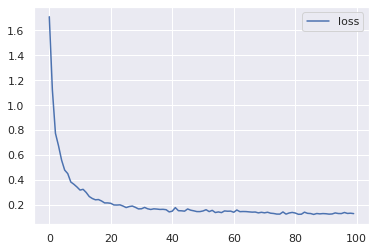

In [ ]:
history_df.plot()

## 2.3 Binary Classification with Neural Networks

When dealing with classification tasks, everything we've covered up till now with regression still applies. The main difference is the format of the last layer's outputs and the choice of loss function.

### 2.3.1 Accuracy and Cross Entropy

Formerly, we've encountered accuracy in classification tasks. It is the ratio of correct predictions over total predictions: `accuracy = number_corect / total` (and when classes were heavily imballanced we used a weighted accuracy). 

The problem with using accuracy as a loss function, is that it does not change smoothly (there are jumps in the numerator since it is just a count in correct predictions), which the SGD algorithm requires in order to work properly. We need another metric.

<p align=center>
<img src="https://i.imgur.com/DwVV9bR.png"></img>

<small> the further a model is from predicting the correct class, the higher the loss. </small>

Instead we use **_cross-entropy_**, we won't go into detail here, other than that it is a distance measure between two probabilities. What two probabilities are we measuring? We want the probability for predicting the correct class to be 1 (100%). cross-entropy will measure the distance the current probability of the model is from 1. The main takeaway here is that we will want to use cross-entropy for classification tasks. 

We set cross-entropy as our loss when we compile the model. In this case we have two classes so we use `binary_crossentropy`

```
model.compile(
    # optimizer...
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)
```



### 2.3.2 0 or 1: The Sigmoid Function

Finally, we need to introduce a special activation function that will map our last layer outputs from 0 to 1, to feed into our loss function. The traditional function we use for this is the **_sigmoid function_**. 

<p align=center>
<img src="https://i.imgur.com/FYbRvJo.png"></img>

<small>The sigmoid function maps values on the interval [0, 1]</small>

To get the final class prediction, we need a threshold probability, typically 0.5 where we will round up to the class label. Keras will set to 0.5 by default.

We set the sigmoid activation function in the last layer:

```
model = keras.Sequential([
    # ... previous layers ...
    layers.Dense(1, activation='sigmoid'),
])
```

### 2.3.3 Classification Example

In [30]:
wine = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
      "ds_for_engineers/main/data/wine_quality/winequalityN.csv")

# create X and y
X = wine.copy()
y = X.pop('type')

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

# the numerical values pipe
num_proc = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

# the categorical values pipe
cat_proc = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore'))

# parallelize the two pipes
preprocessor = make_column_transformer((num_proc,
                                make_column_selector(dtype_include=np.number)),
                                       (cat_proc,
                                make_column_selector(dtype_include=object)))

X_train_std = preprocessor.fit_transform(X_train) # fit_transform on train
X_test_std = preprocessor.transform(X_test) # transform test
X_val_std = preprocessor.transform(X_val)

y_train_std = y_train.map({'white': 0, 'red': 1}) # convert to int
y_val_std = y_val.map({'white': 0, 'red': 1}) # convert to int
y_test_std = y_test.map({'white': 0, 'red': 1}) # convert to int

preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd575be2290>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd575e14790>)])

In [36]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=[X_train_std.shape[1]]),
    layers.Dense(4, activation='relu'),    
    layers.Dense(1, activation='sigmoid'),
])

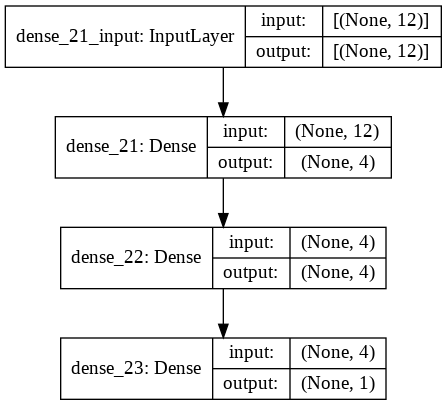

In [37]:
tf.keras.utils.plot_model(model, 
                          show_layer_names=True, 
                          # show_dtype=True, 
                          show_shapes=True)

We set cross-entropy as our loss when we compile the model. In this case we have two classes so we use `binary_crossentropy`

In [33]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [34]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train_std, y_train_std,
    validation_data=(X_val_std, y_val_std),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

Best Validation Loss: 0.0150
Best Validation Accuracy: 0.9984


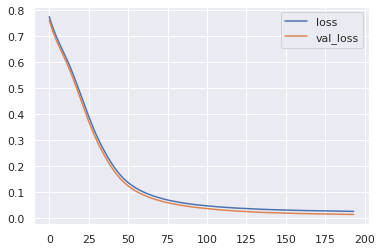

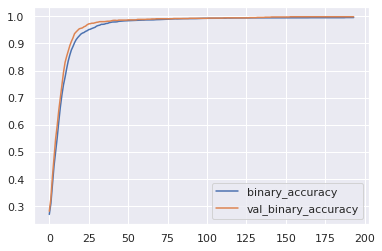

In [35]:
history_df = pd.DataFrame(history.history)

history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

## 2.3.4 Multi-Class Classification

[back to top](#top)

### Exercise: Define a Model with this Architecture

1) Define Model

Define a model with both batch normalization and dropout layers. 

Define a model with an architecture given by this diagram:

<insert diagram>

2) Add Optimizer, Loss, and Metric

Compile the model with the Adam optimizer and binary versions of the cross-entropy loss and accuracy metric.

3) Train and Evaluate

What do you think about the learning curves? Does it look like the model underfit or overfit? Was the cross-entropy loss a good stand-in for accuracy?

In [72]:
from keras.utils import np_utils

In [67]:
wine = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
      "ds_for_engineers/main/data/wine_quality/winequalityN.csv")

# create X and y
X = wine.copy()
y = X.pop('quality')

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

# the numerical values pipe
num_proc = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

# the categorical values pipe
cat_proc = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore'))

# parallelize the two pipes
preprocessor = make_column_transformer((num_proc,
                                make_column_selector(dtype_include=np.number)),
                                       (cat_proc,
                                make_column_selector(dtype_include=object)))

X_train_std = preprocessor.fit_transform(X_train) # fit_transform on train
X_test_std = preprocessor.transform(X_test) # transform test
X_val_std = preprocessor.transform(X_val)

y_train_std = y_train.values.astype(int)
y_val_std = y_val.values.astype(int)
y_test_std = y_test.values.astype(int)

preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd57a7fd210>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd57a31cdd0>)])

In [77]:
enc = LabelEncoder()
enc.fit_transform(y_train)

array([3, 3, 3, ..., 3, 2, 4])

In [78]:
y_train

4844    6
245     6
3424    6
4377    6
3109    4
       ..
4154    5
208     5
2544    6
2769    5
1837    7
Name: quality, Length: 3654, dtype: int64

In [68]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=[X_train_std.shape[1]]),
    layers.Dense(4, activation='relu'),    
    layers.Dense(1, activation='sigmoid'),
])

In [69]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [70]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train_std, y_train_std,
    validation_data=(X_val_std, y_val_std),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=1, # hide the output because we have so many epochs
)

Epoch 1/1000
8/8 [==============================] - 1s 23ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/1000
8/8 [==============================] - 0s 7ms/step

Best Validation Loss: 0.0000
Best Validation Accuracy: 0.0000


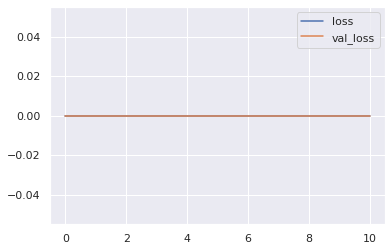

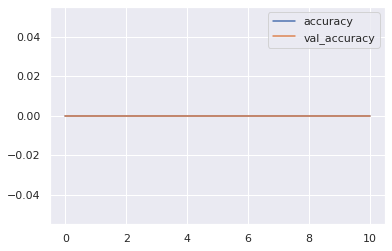

In [71]:
history_df = pd.DataFrame(history.history)

history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

# References

[Difference between a batch and an epoch](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/)

[Cross Entropy](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)